In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os

import numpy as np
from skimage import io
from skimage.color import rgb2gray
from skimage.transform import resize
import torch
from torch.utils.data import Dataset

from torch import Tensor

from numbers import Number
from typing import Union

from torch.nn import Sequential
import torchvision.transforms as tvts
from torch.utils.data import IterableDataset, IterDataPipe
from torchdata.datapipes.iter import Mapper, IterableWrapper
from torchdata.datapipes.iter import FileLister

from matplotlib import pyplot as plt

%matplotlib inline

from icecream import ic
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
from sklearn.metrics import mean_squared_error

DEVICE = 'cuda'

%run DDRM_sampling.ipynb
%run galaxy_ds.ipynb

In [2]:
!nvidia-smi

Thu Jul 27 12:13:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:31:00.0 Off |                  Off |
| N/A   29C    P0    49W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In this notebook I will try to produce the source reconstruction results of the group's DDRM Paper. I utilize my DDPM.

In [3]:
# Let's import the Hlens matrix that we will be using!

lensing_Hb = torch.load('lensing_Hb.pth')
lensed_image = torch.load('rgb_down_img.pth')

In [4]:
prior = torch.load('good_prior.pth')

In [5]:
print(lensing_Hb.shape)
print(lensed_image.shape)

torch.Size([3, 100, 100, 3, 64, 64])
torch.Size([3, 100, 100])


In [6]:
# Now let's load the pretrained models to see what samples they return

# Let's start by getting some DDPM prior samples'

probes_model_path = '/home/smarkesinis/astroddpm/logs/probes/03000000-model.pt'
ddpmds = DDPMDataset.from_pretrained_astroddpm(probes_model_path, map_location='cuda')

In [7]:
ddrmds = DDRMDataset.from_pretrained_astroddpm(probes_model_path, 
                                               Hb=lensing_Hb,
                                               multi_channel=True,
                                               map_location='cuda')

# multi_channel=False --> from 3 channels src to 1 channel img using mean of H

In [8]:
print(ddrmds.Hb.shape)
print(ddrmds.H.shape)

torch.Size([3, 100, 100, 3, 64, 64])
torch.Size([30000, 12288])


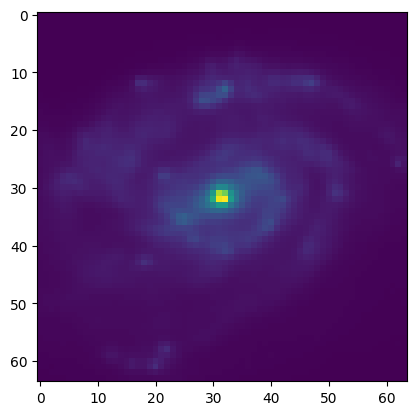

In [9]:

plt.imshow(prior[0].cpu())

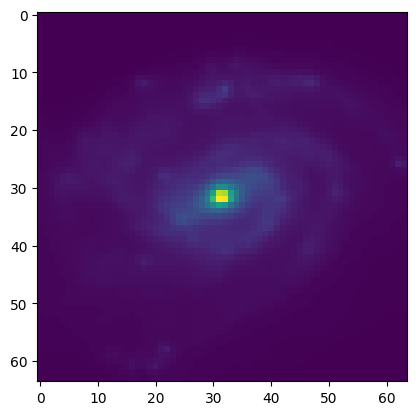

In [10]:
plt.imshow(prior.mean(0).cpu())

In [11]:
obs = (ddrmds.H @ prior.flatten()).reshape(3,100,100)

In [12]:
noise = obs.max()/10
obs = obs + torch.rand_like(obs) * noise

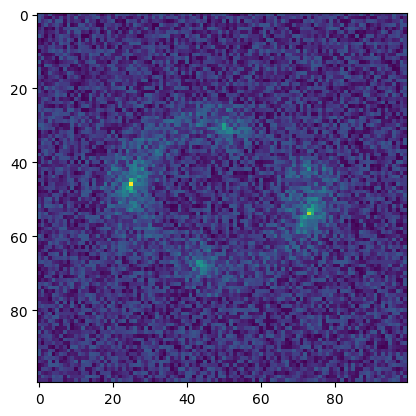

In [13]:
plt.imshow(obs[0].detach().cpu())

In [14]:

ddrmds = DDRMDataset.from_pretrained_astroddpm(probes_model_path, 
                                               Hb=lensing_Hb,
                                               y=obs.flatten(),
                                               sigma_y=noise,
                                               nbatch=6,
                                               eta=1, 
                                               eta_b=0.85,
                                               multi_channel=True,
                                               map_location='cuda')

In [15]:
samples = next(cycle(ddrmds))

SVD-ing


99it [00:03, 32.58it/s]


In [16]:
samples.shape

torch.Size([6, 3, 64, 64])

In [17]:
samples = samples.mean(0).cpu()

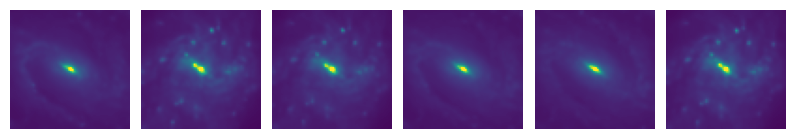

In [16]:
imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower')

fig, axs = plt.subplots(1, 6, sharex='all', sharey='all', figsize=(10, 5))

for ax, src_img in zip(axs.flatten(), samples.mean(1)):
    ax.imshow(src_img.detach().cpu(), vmin=0, vmax=0.5, **imkwargs)
    ax.set_axis_off()
    
plt.subplots_adjust(wspace=0.1)  # Adjust the spacing between subplots

plt.show()

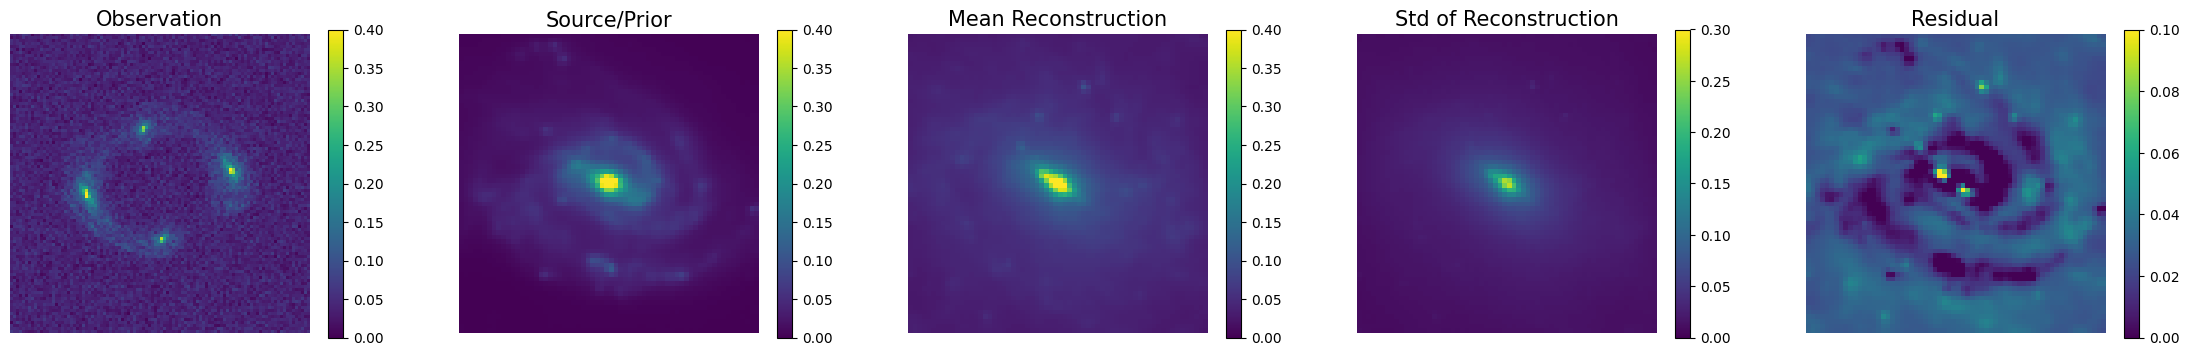

In [20]:
imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower')

fig, axs = plt.subplots(1, 5, sharex='all', sharey='all', figsize=(28, 4))

titles = ['Observation', 'Source/Prior', 'Mean Reconstruction', 'Std of Reconstruction','Residual']  # Titles for each image
vmaxs = [0.4,0.4,0.4,0.3,0.1]



for ax, im, title, vmax in zip(axs, (obs.mean(0).cpu(), prior.mean(0).cpu(), samples.mean(0).cpu().detach().numpy(),samples.std(0).cpu().detach().numpy(), samples.mean(0).cpu().detach().numpy() - prior.mean(0).cpu().numpy()), titles, vmaxs):
    im = ax.imshow(im, vmin=0, vmax=vmax, **imkwargs)
    plt.colorbar(im, ax=ax)
    ax.set_axis_off()
    ax.set_title(title, fontsize=15)  # Add title above each image

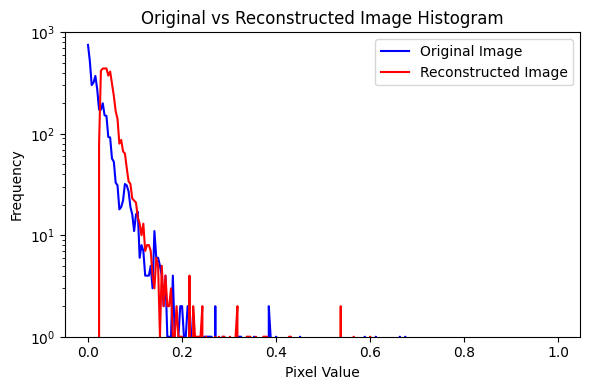

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'original_image' and 'reconstructed_image' are your two (3, 64, 64) images
original_image = prior.cpu().detach().numpy()
reconstructed_image = samples.cpu().detach().numpy()

# Reshape the images to (64, 64, 3)
original_image = original_image.transpose(1, 2, 0)
reconstructed_image = reconstructed_image.transpose(1, 2, 0)

# Convert the images to grayscale
original_gray = np.mean(original_image, axis=2)
reconstructed_gray = np.mean(reconstructed_image, axis=2)

# Calculate the histograms
bins = np.linspace(0, 1, num=256)
original_hist, _ = np.histogram(original_gray.flatten(), bins=bins)
reconstructed_hist, _ = np.histogram(reconstructed_gray.flatten(), bins=bins)

# Plot the histograms
plt.figure(figsize=(6, 4))
plt.title('Original vs Reconstructed Image Histogram')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.ylim(1,1000)
plt.plot(bins[:-1], original_hist, color='blue', label='Original Image')
plt.plot(bins[:-1], reconstructed_hist, color='red', label='Reconstructed Image')
plt.legend()

plt.tight_layout()
plt.show()

In [32]:
original_image[original_image>0.3].shape

(49,)

In [15]:
def get_samples(eta, eta_b, y, noise, nsamples, clip=True):
    Y = 2*y - ddrmds.H.sum(-1) # normalization

    return (ddrmds.sample(
        Y.expand(nsamples, *Y.shape[-3 if ddrmds.multi_channel else -2:]),
        2 * noise, clip=clip, eta=eta, eta_b=eta_b
    ) + 1) / 2


In [16]:
import torchvision.models as models

# Define the perceptual loss function
class PerceptualLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.vgg16(weights='VGG16_Weights.IMAGENET1K_V1').features[:23]
        for param in self.model.parameters():
            param.requires_grad = False
        self.loss_fn = nn.MSELoss()

    def forward(self, x, y):
        x_features = self.model(x)
        y_features = self.model(y)
        return self.loss_fn(x_features, y_features)

In [17]:
# Create an instance of the perceptual loss function
perceptual_loss = PerceptualLoss()
perceptual_loss.to(DEVICE)

PerceptualLoss(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [18]:
scale = (1,1.5)
my_trans = transforms.Compose([
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(0.5),
    #transforms.RandomRotation((0,3)),
    transforms.RandomAffine(
                degrees=(0,3),
                translate=(0.01,0.02),
                scale=(1/scale, scale) if isinstance(scale, Number) else scale,
    )])
                   
    
augmented = [my_trans(prior) for _ in range(100) ]

In [19]:
len(augmented)

100

In [20]:
# Objective Function (measure of the quality of reconstructed images)

def objective(x):
    
    
    eta, eta_b = x
   
    reconstructed_images = get_samples(eta, eta_b,y, noise=1.,nsamples=5)
    reconstructed_image = reconstructed_images.mean(0)
    reconstructed_image = reconstructed_image.to(DEVICE)
    #print(reconstructed_image.shape)
    #print(reconstructed_images.shape)
   
    ground_truth_image = torch.stack(augmented)
    ground_truth_image = torch.mean(ground_truth_image,axis=0)
    reconstructed_image = reconstructed_image.reshape(3,64,64)
    
    # detach the tensors to save memory
    ground_truth_image = ground_truth_image.detach()
    reconstructed_image = reconstructed_image.detach()

    # Compute the mean squared error between the reconstructed image and the ground truth
    #mse = torch.nn.functional.mse_loss(reconstructed_image, ground_truth_image)
    
    pl = perceptual_loss(reconstructed_image, ground_truth_image)
    #total_loss = mse + pl
    return pl

    

In [21]:
# Define the search space for the hyperparameters
search_space = [
    Real(0.01, 1, name='eta'),
    Real(0.01, 1, name='eta_b'),
]

# Specify the Gaussian process prior over the objective function

kernel = Matern(length_scale=1.0, nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=0.1)

In [22]:
# Define the optimization loop
@use_named_args(search_space)
def optimization_loop(**params):
    
    # Evaluate the objective function
    objective_values = []
    for i in range(2):
        objective_value = objective([params['eta'], params['eta_b']])
        objective_values.append(objective_value)
    
    # Compute the mean objective value over the evaluations
    objective_values = torch.Tensor(objective_values)
    objective_value = torch.mean(objective_values).item()
    print(objective_value)
    print(params['eta'])
    print(params['eta_b'])
    # Update the Gaussian process prior
    X = np.array([[params['eta'], params['eta_b']]])
    y = np.array([objective_value])
    gp.fit(X, y)
    
    # Return the objective value
    return objective_value


In [23]:
# Run the Bayesian optimization loop
result = gp_minimize(
    optimization_loop,       # optimization loop function to minimize
    search_space,            # search space for hyperparameters
    acq_func='EI',           # acquisition function to use (expected improvement)
    n_calls=1000,              # number of function evaluations (i.e., hyperparameter settings) to use
    n_random_starts=1000,       # number of random initializations before starting the optimization loop
    verbose=True,            # enable verbose output
    n_jobs=-1,               # number of parallel jobs to run (-1 for using all available processors)
    random_state=10,         #
)

Iteration No: 1 started. Evaluating function at random point.


NameError: name 'y' is not defined

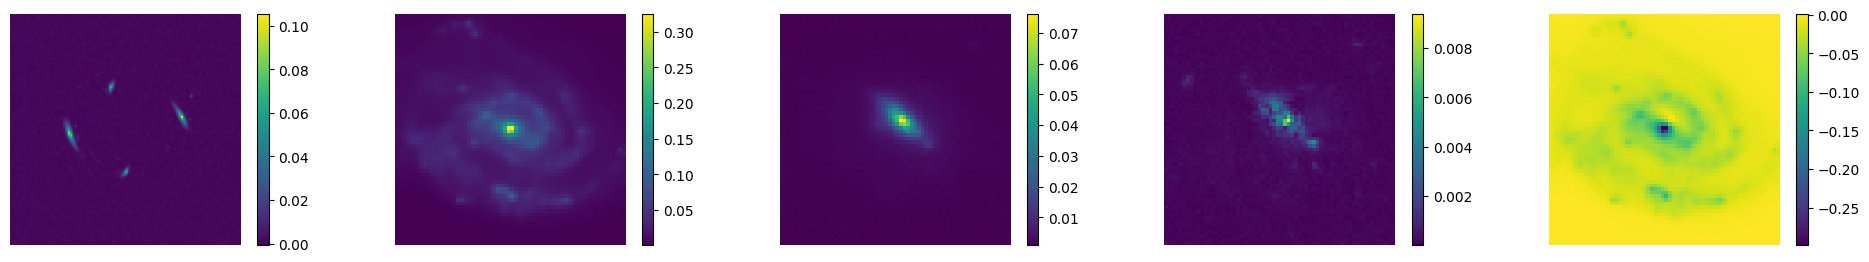

In [17]:
imkwargs = dict(extent=(-1, 1, -1, 1), origin='lower')

fig, axs = plt.subplots(1, 5, sharex='all', sharey='all', figsize=(24, 3))

for ax, im in zip(axs, (obs[0].cpu(), prior[0].cpu(), samples.mean(0), samples.std(0), samples.mean(0) - prior[0].cpu())):
    im = ax.imshow(im.detach(), **imkwargs)
    plt.colorbar(im, ax=ax);
    ax.set_axis_off()
